In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdriver')

<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [2]:
!pip install ml_collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.3 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=550bbe94d7c153e26d6b234681fd5b9024eb8506217890c77e6f3e4aa47af28e
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


# Import neccessary library

In [3]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

# Load model

## Load ViT-B16-224 pretrained model

The model is used for this research is ViT-B16, which has input shape (224, 224, 3) and is trained on ImageNet21k + ImageNet2012 datasets. The pretrain model's weights lists in [table expected ViT results](https://github.com/google-research/vision_transformer#expected-vit-results). You can download model as below:

In [17]:
!mkdir -p weights
!wget -O weights/ViT-B_16-224.npz /tmp/Ubuntu.iso https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz

/tmp/Ubuntu.iso: Scheme missing.
--2022-05-25 15:49:39--  https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346335542 (330M) [application/octet-stream]
Saving to: ‘weights/ViT-B_16-224.npz’

weights/ViT-B_16-22 100%[===================>] 330.29M  49.3MB/s    in 7.8s    

2022-05-25 15:49:47 (42.1 MB/s) - ‘weights/ViT-B_16-224.npz’ saved [346335542/346335542]

FINISHED --2022-05-25 15:49:47--
Total wall clock time: 8.1s
Downloaded: 1 files, 330M in 7.8s (42.1 MB/s)


Now pretrain weights are in `weights` folder. So we can initialize ViT model by loading pretrain weights:

In [4]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()
print('model change model evaluation is successful!')

model change model evaluation is successful!


This CNN backbone take responsibility of extracting 768 input views, which are relevant to each image patch. Those image patches will be used to create the view of the input image at layer 0.

In [7]:
backbone_cnn = model._modules['transformer'].embeddings

# Prediction

## Preprocessing image

The image is fowarded into the processing steps is the same as original repo [ViT](https://github.com/google-research/vision_transformer)

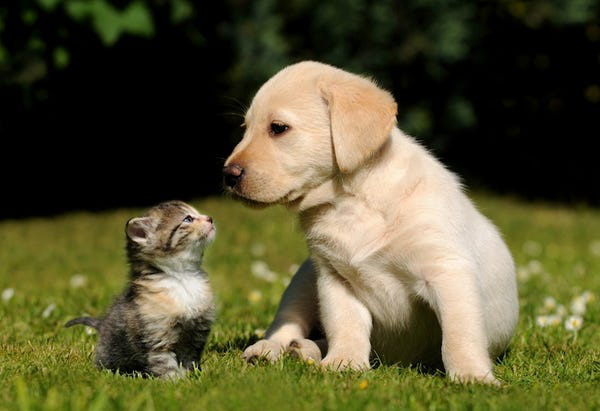

In [54]:
def _preprocess(url):
  urlretrieve(url, "attention_data/img.jpg")
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  ])
  im = Image.open("attention_data/img.jpg")
  x = transform(im)
  return x, im

x, im = _preprocess('https://imgur.com/0pqitQt.png')
im

# Cumulative product of attention weights

This part calculates cumulative products of attention weights over 12 layers

In [6]:
logits, att_mat = model(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
att_mat = torch.mean(att_mat, dim=1) 
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# Recursively multiply the weight matrices over 12 layers.
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
# The mask matrices over 12 layers correspond with the normal tokens and the class token.
masks = [] # mask matrices of normal tokens
masks_cls = [] # mask matrice of class token
for i in range(len(joint_attentions)):
  v = joint_attentions[i] # [n_tokens, n_tokens]
  mask = v[1:, 1:] # 196x196
  mask = mask/mask.max(axis=0).values
  mask = mask / mask.max() # [im_w, im_h, 1]
  masks.append(mask)
  mask_cls = v[0, 1:] # Attention of token class with patch token
  mask_cls = mask_cls / mask_cls.max() # [im_w, im_h, 1]
  masks_cls.append(mask_cls)

# Define function of attention maps

### Input feature map layers 0

We calculate the input view (or _activation map_) at layers 0 by element-wise product between each filter and specific patch. There are three functions with their means that is:

* __create_input_activation_map_of_patch_filter()_: a view of a specific patch and a specific filter.
* __visual_view_patch_filter()_: a view of a specific filter.
* __create_activation_map()_: a global view of whole patches, which are aranged into an image according to their original patch's position, of the given filter.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

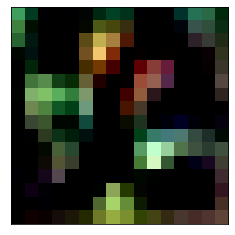

In [19]:
def _create_input_activation_map_of_patch_filter(
    x: torch.Tensor, idx_patch: int = 0, idx_filter: int = 0
    ) -> torch.Tensor:
  '''
  This function calculates the view of a specific patch and filter
  Args:
    x (torch.Tensor): input image
    idx_patch (int): the index of the patch
    idx_filter (int): the index of filter
  Return:
    patch_mul (torch.Tensor): the output view is relevant to input patch and filter.
  '''
  i = idx_patch // 14
  j = idx_patch % 14
  with torch.no_grad():
    filter_idx = backbone_cnn._modules['patch_embeddings'].weight[idx_filter, :, :, :]
  patch = x[:, (i*16):((i+1)*16), (j*16):((j+1)*16)]
  patch_mul = patch*filter_idx
  patch_mul = patch_mul/patch_mul.max()
  patch_mul = patch_mul.permute(1, 2, 0)
  return patch_mul

patch_mul = _create_input_activation_map_of_patch_filter(x, 0, 765)
plt.imshow(patch_mul.detach().numpy())
plt.xticks([])
plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

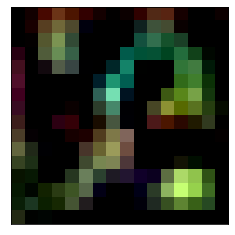

In [22]:
def _visual_view_patch_filter(
    idx_filter: int = 0
  ) -> torch.Tensor:
  '''
  This function to visualize the view of a specific filter
  Args:
    idx_filter (int): the index of filter
  Return:
    filter_idx (torch.Tensor): the view of filter
  '''
  with torch.no_grad():
    filter_idx = backbone_cnn._modules['patch_embeddings'].weight[idx_filter, :, :, :]
    filter_idx /= filter_idx.max()
    filter_idx = filter_idx.permute(1, 2, 0).detach().numpy().copy()
  return filter_idx

filter_idx = _visual_view_patch_filter(idx_filter=765)
plt.imshow(filter_idx)
plt.xticks([])
plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

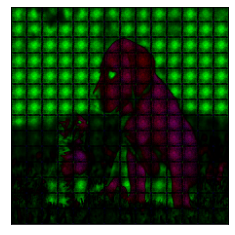

In [59]:
def _create_activation_map(
    x: torch.Tensor, idx_filter: int = 0, view_type: str = 'max'
    ) -> torch.Tensor:
  '''
  This function calculates the global view of a specific filter 
  by arranging the whole patches according to original positions in input image.
  Args:
    x (torch.Tensor): input image
    idx_filter (int): the index of filter
    view_type (str, default{'max','constrast'}): the type of normalize the image view.
      'max' will devide to maximum value of tensor and 'constrast' will apply exponential to make color constrastive.
  Return:
    act_map_idx (torch.Tensor): the global view is relevant to input filter.
  '''
  act_map_idx = torch.zeros_like(x, dtype=torch.float32)
  for i in range(14):
    for j in range(14):
      filter_idx = backbone_cnn._modules['patch_embeddings'].weight[idx_filter, :, :, :]
      patch = x[:, (i*16):((i+1)*16), (j*16):((j+1)*16)]
      patch_mul = patch*filter_idx
      act_map_idx[:, (i*16):((i+1)*16), (j*16):((j+1)*16)] = patch_mul
  if view_type == 'max':
    act_map_idx = act_map_idx/act_map_idx.max()
  elif view_type == 'constrast':
    act_map_idx = ((act_map_idx/act_map_idx.max())**2)*act_map_idx
  act_map_idx = act_map_idx.permute(1, 2, 0)
  return act_map_idx

act_map_idx = _create_activation_map(x, idx_filter=3, view_type='max')
plt.imshow(act_map_idx.detach().numpy())
plt.xticks([])
plt.yticks([])

### The higher layers

We create a function calculating the view at the layer `i'th` in order to:

* __create_activation_map_of_patch_filter_layer()_: View of specific patch, specific filter, and specific layer.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


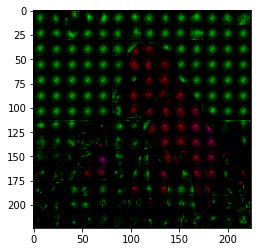

In [60]:
def _create_activation_map_of_patch_filter_layer(
    x: torch.Tensor, idx_patch: int = 0, idx_filter: int = 0, idx_layer: int = 0
  ) -> torch.Tensor:
  '''
  This function to calculate the view of a specific patch and a specific filter
  Args:
    x (torch.Tensor): input image
    idx_patch (int): the index of the patch
    idx_filter (int): the index of filter
    idx_layer (int): the index of layer
  Return:
    patch_mul (torch.Tensor): the output global view according to the input patch, filter and layer.
  '''
  mask = masks[idx_layer]
  mask_i = mask[idx_patch, :].reshape(14, 14)
  input_idx_patch = 0
  patch_mul = torch.zeros((224, 224, 3), dtype=torch.float32)
  for i in range(14):
    for j in range(14):
      view_ij = _create_input_activation_map_of_patch_filter(x, input_idx_patch, idx_filter)
      patch_mul[(i*16):((i+1)*16), (j*16):((j+1)*16), :] = mask_i[i, j] * view_ij
      input_idx_patch += 1
  patch_mul = ((patch_mul/patch_mul.max())**2)*patch_mul
  return patch_mul
  
patch_mul = _create_activation_map_of_patch_filter_layer(x, idx_patch = 3, idx_filter = 3, idx_layer = 11)
plt.imshow(patch_mul.detach().numpy())

# Analyze global view in the layer 0'th

To analysze that each filter will a specific image group but not good with the other image groups we prepare a 10 images saved in `attention_data/img_test` foler: 

In [34]:
# Take the list of image names in 'attention_data/img_test' folder
for root, _, img_urls in os.walk('attention_data/img_test/'):
  print(len(img_urls))

10


In [43]:
# This function to read a specific image from attention_data/img_test folder
def _preprocess_list(img_name):
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  ])
  im = Image.open("attention_data/img_test/{}".format(img_name))
  x = transform(im)
  return x, im

Show all images in `attention_data/img_test` folder:

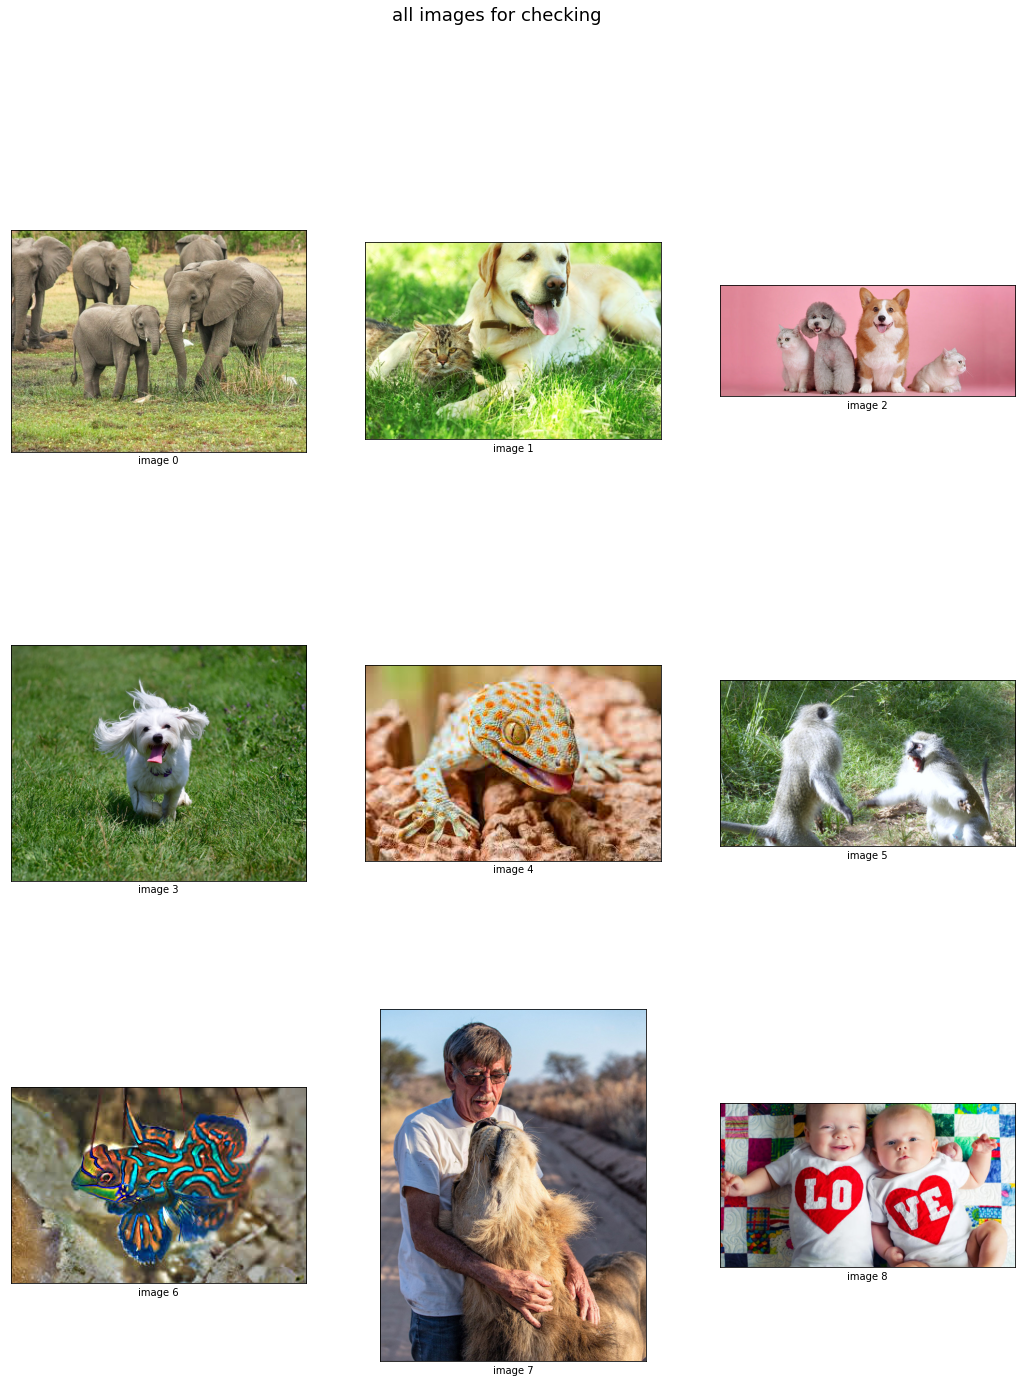

In [53]:
fg, ax = plt.subplots(3, 3, figsize=(18, 22))
fg.suptitle('all images for checking', fontsize=18)
idx_url = 0
for i in range(3):
  for j in range(3):
    img_url = img_urls[idx_url]
    try:
      _, im = _preprocess_list(img_url)
      ax[i, j].imshow(np.array(im))
      ax[i, j].set_xlabel('image {}'.format(idx_url))
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
    except:
      print('Error at image {}'.format(idx_url))
    idx_url += 1

## Each filter will be good with each objects

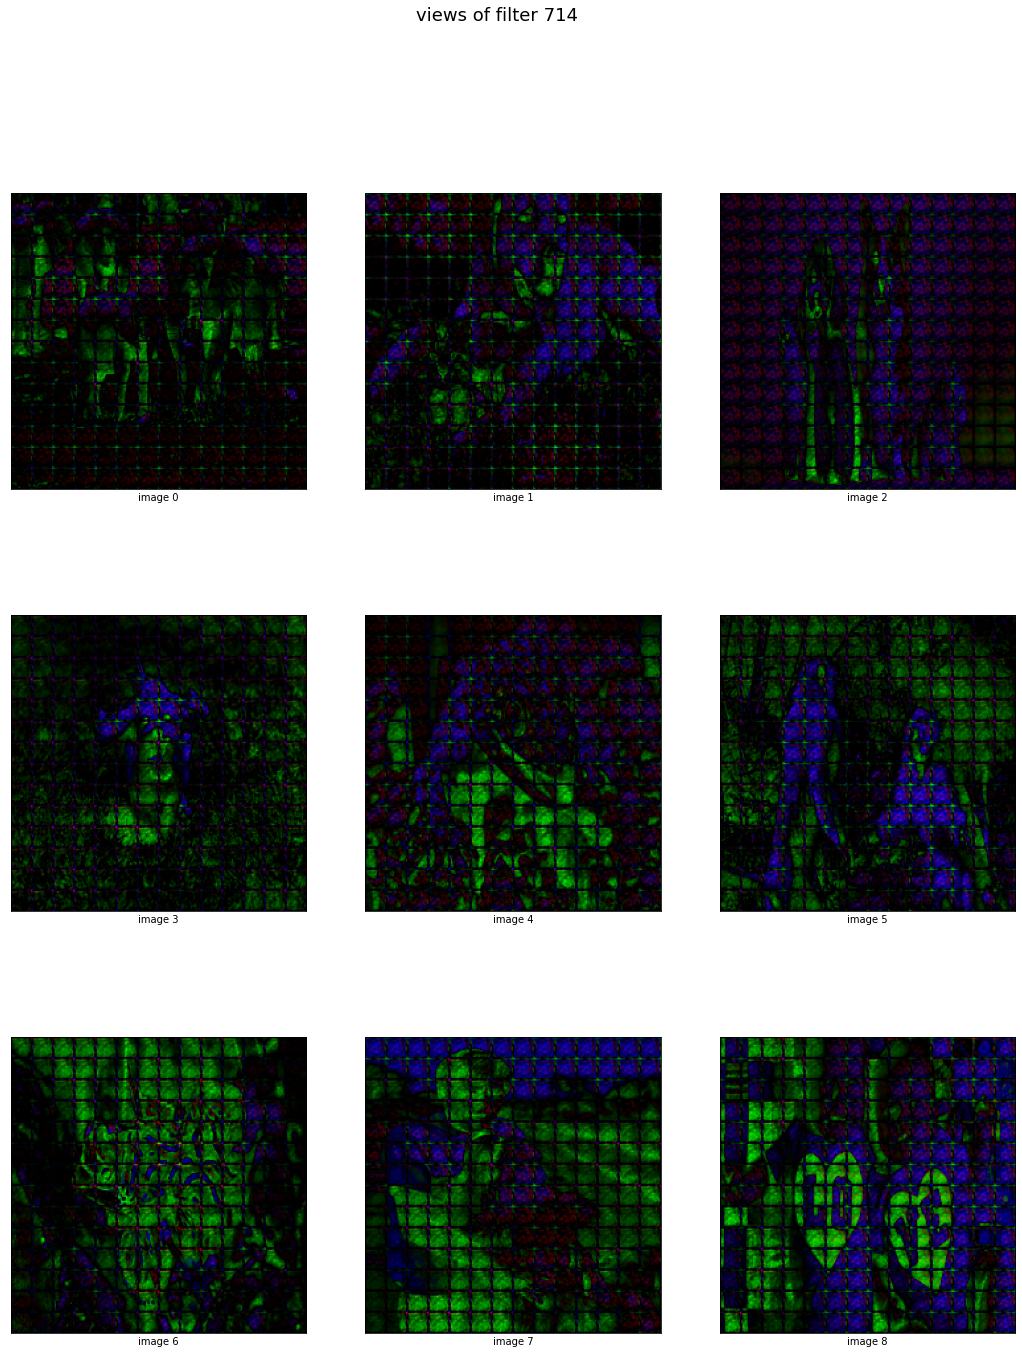

In [41]:
idx_filter = 714
fg, ax = plt.subplots(3, 3, figsize=(18, 22))
fg.suptitle('views of filter {}'.format(idx_filter), fontsize=18)
idx_url = 0
for i in range(3):
  for j in range(3):
    img_url = img_urls[idx_url]
    x, im = _preprocess_list(img_url)
    activation_map = _create_activation_map(x, idx_filter = idx_filter, view_type = 'max')
    activation_map = activation_map/activation_map.max()
    activation_map = activation_map.clip(0, 1)
    ax[i, j].imshow(activation_map.detach().numpy())
    ax[i, j].set_xlabel('image {}'.format(idx_url))
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    idx_url += 1

714'th filter is good with image 6 (a fish) and 0 (elephant) but not good with the others.

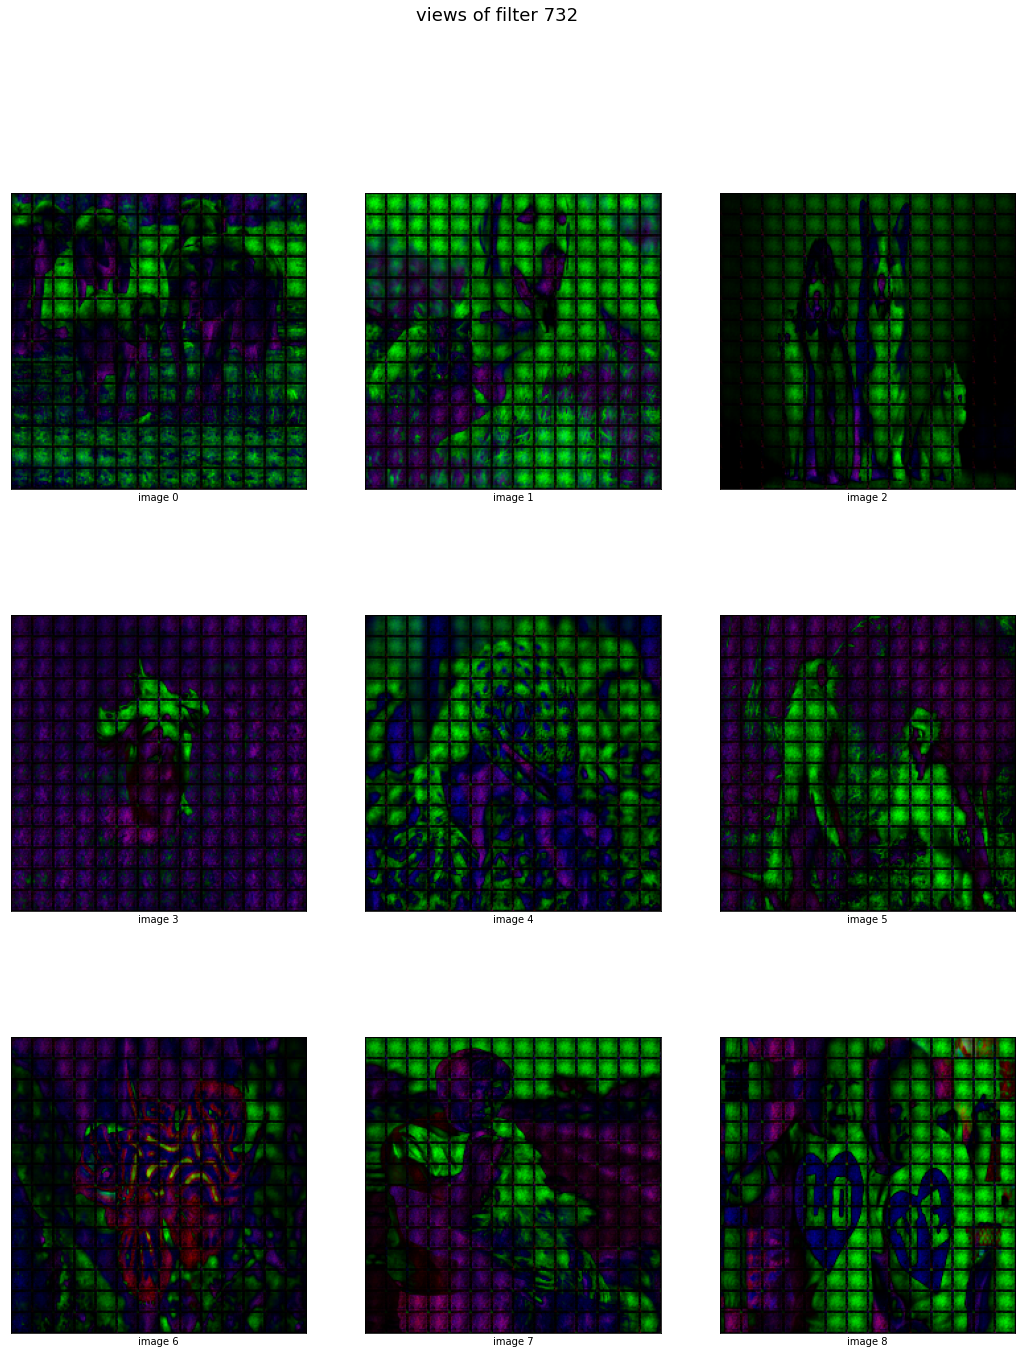

In [42]:
idx_filter = 732
fg, ax = plt.subplots(3, 3, figsize=(18, 22))
fg.suptitle('views of filter {}'.format(idx_filter), fontsize=18)
idx_url = 0
for i in range(3):
  for j in range(3):
    img_url = img_urls[idx_url]
    try:
      x, im = _preprocess_list(img_url)
      activation_map = _create_activation_map(x, idx_filter = idx_filter, view_type = 'max')
      activation_map = activation_map/activation_map.max()
      activation_map = activation_map.clip(0, 1)
      ax[i, j].imshow(activation_map.detach().numpy())
      ax[i, j].set_xlabel('image {}'.format(idx_url))
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
    except:
      print('Error at image {}'.format(idx_url))
    idx_url += 1

732'th filter is good with monkeys, baby, elephant but not good with fish

# Analyze global view in the higher layers:



## Position information and global views over layers 

In low layer: the position information is oustanding. In high layer the gobal contexts are much more outstanding. 

In [87]:
def _vis_act_map_of_same_path_same_filter(x, idx_patch=0, idx_filter=0):
  fg, ax = plt.subplots(4, 3, figsize=(18, 22))
  fg.suptitle('views of patch {} filter {}'.format(idx_patch, idx_filter), fontsize=18)
  idx_layer = 0
  for i in range(4):
    for j in range(3):
      activation_map = _create_activation_map_of_patch_filter_layer(x, idx_patch = idx_patch, idx_filter = idx_filter, idx_layer = idx_layer)
      activation_map = activation_map.clip(0, 1)
      ax[i, j].imshow(activation_map.detach().numpy())
      ax[i, j].set_xlabel('filter {}, layer {}'.format(idx_filter, idx_layer))
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      idx_layer += 1

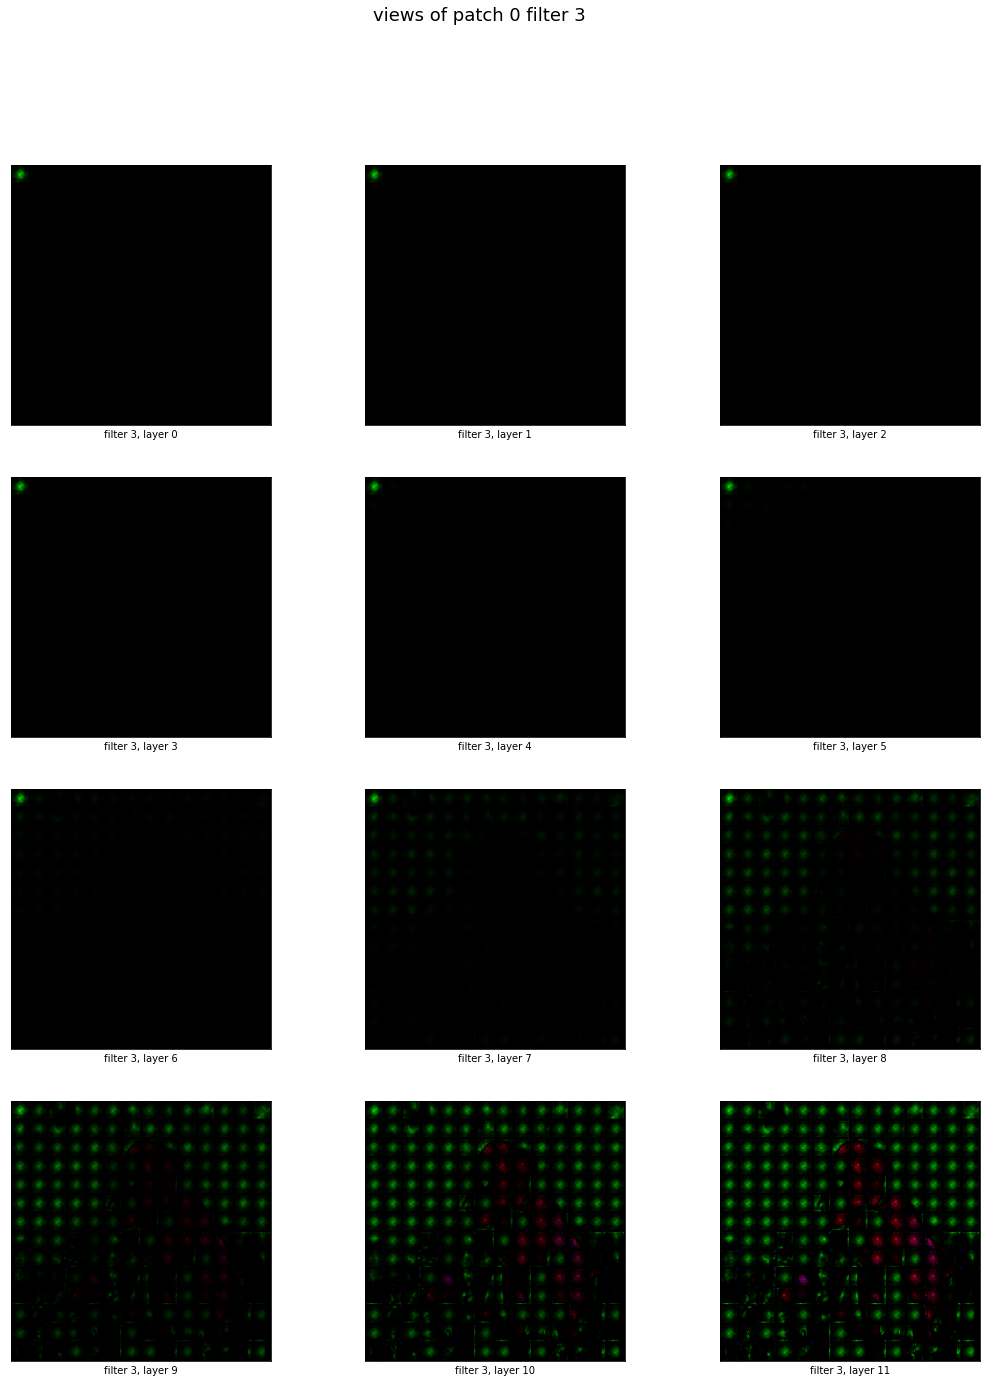

In [88]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=0, idx_filter=3)

# Visualize neuron correspond to background and foreground

## Background

We select the neuron that is in patch 0'th. 

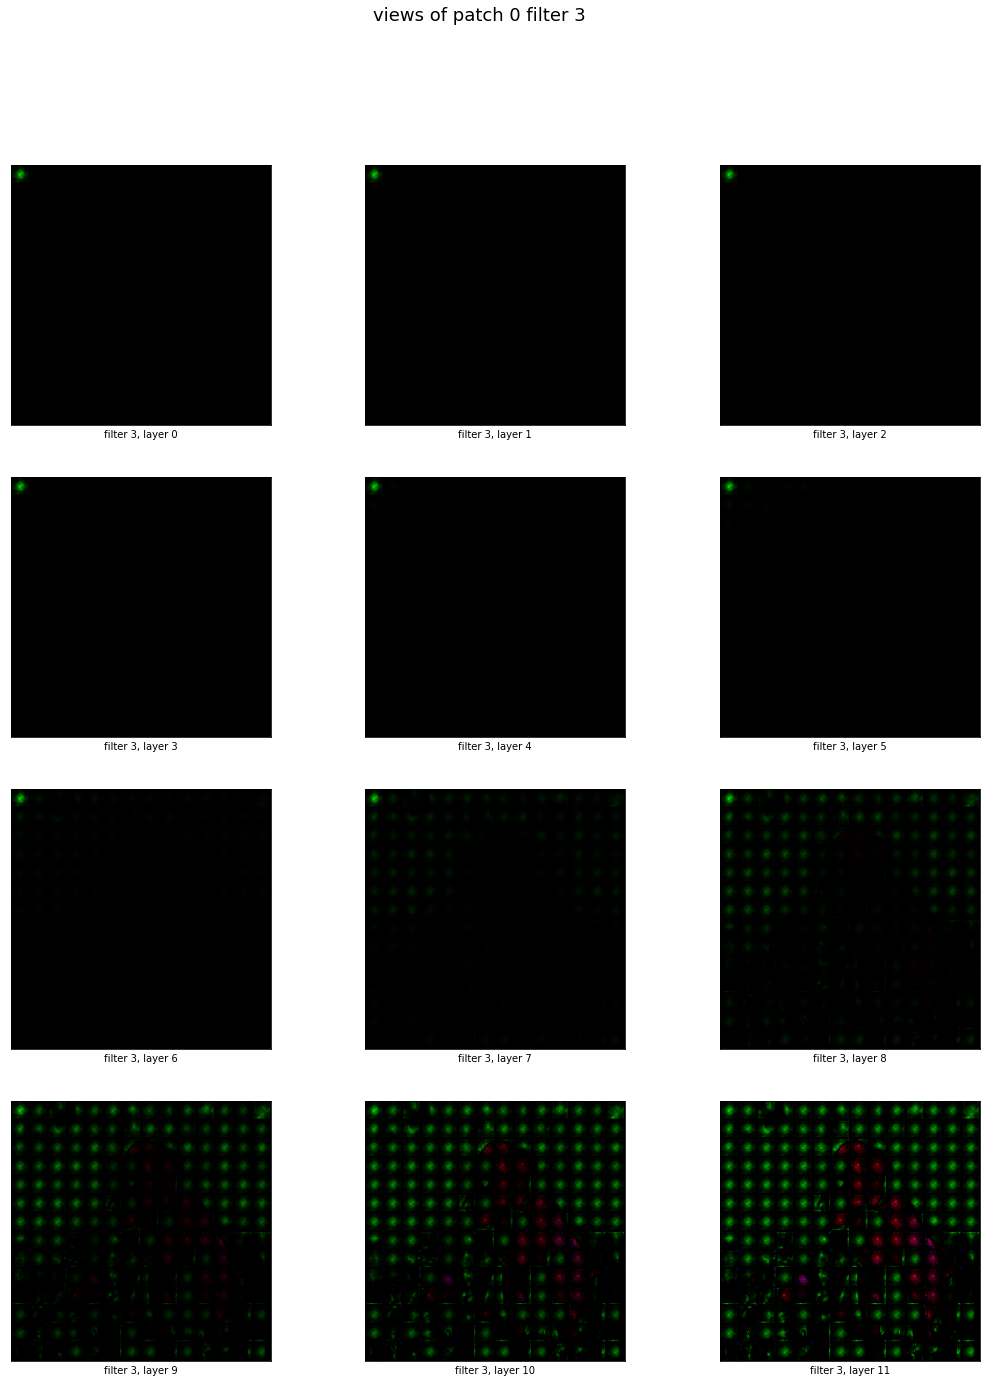

In [95]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=0, idx_filter=3)

## Foreground

We will select the patches in two position 62'th and 78'th that are eye and neck of dog in relative.



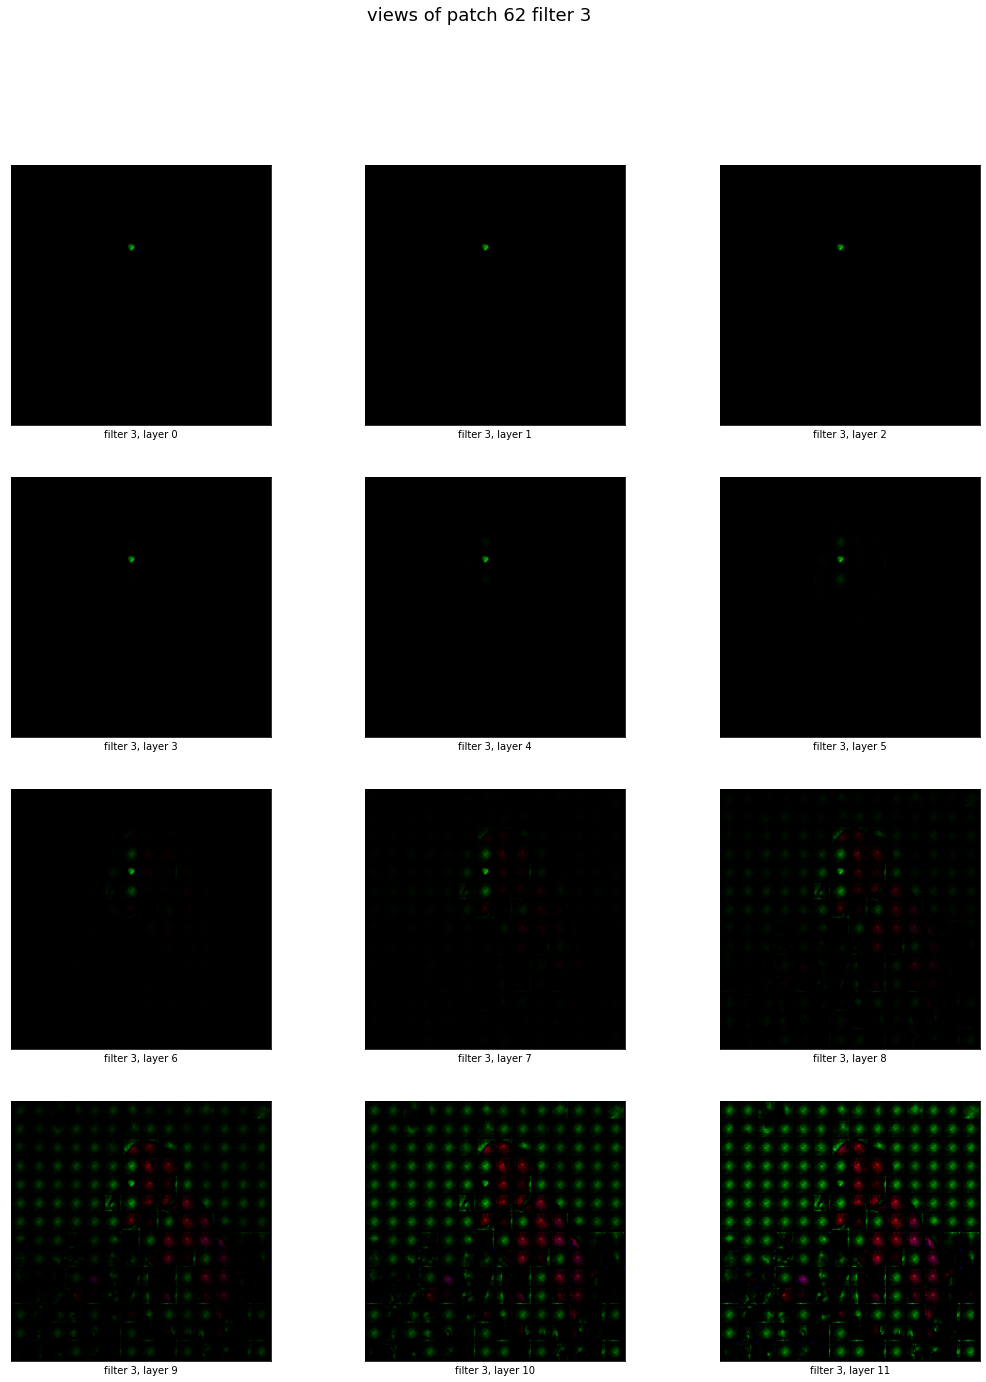

In [90]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=62, idx_filter=3)

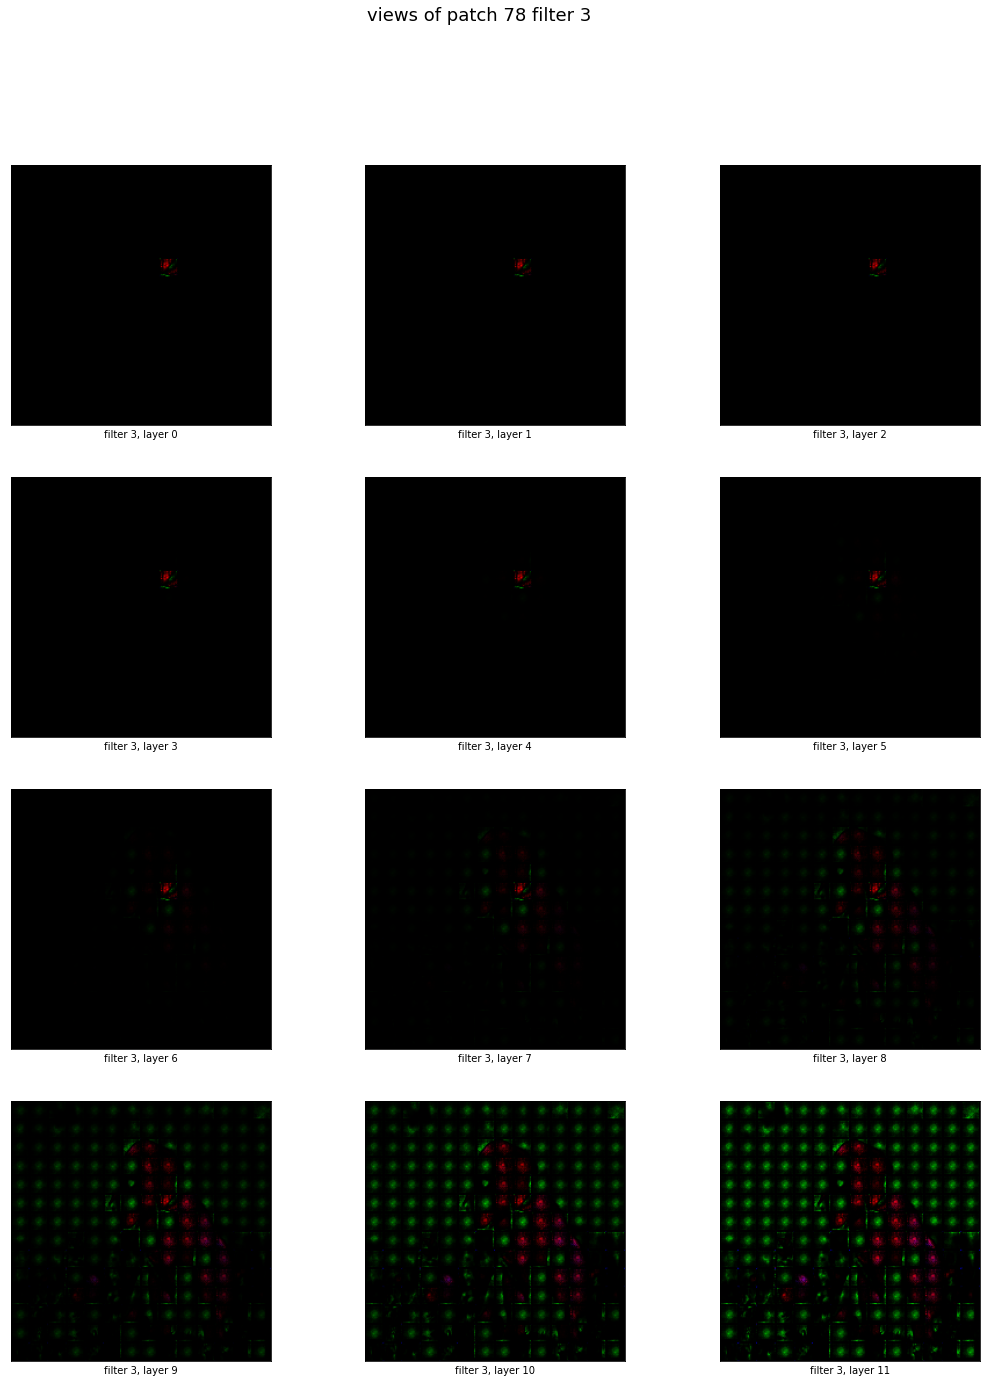

In [91]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=78, idx_filter=3)

## Token class visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


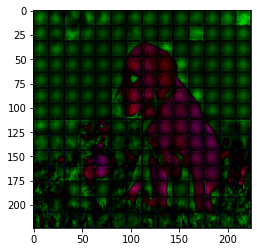

In [64]:
def _create_activation_map_of_clstk_filter_layer(
    x: torch.Tensor, idx_filter: int = 0, idx_layer: int = 0
    ) -> torch.Tensor:
  '''
  This function calculates the global view of class token and a specific filter
  Args:
    x (torch.tensor): input image
    idx_filter (int): the index of filter
    idx_layer (int): the index of layer
  Return:
    patch_mul (torch.Tensor): the output tensor image view of token class.
  '''
  mask_cls = masks_cls[idx_layer]
  mask_i = mask_cls.reshape(14, 14)
  # create a view for current unit 
  input_idx_patch = 0
  patch_mul = torch.zeros((224, 224, 3), dtype=torch.float32)
  for i in range(14):
    for j in range(14):
      view_ij = _create_input_activation_map_of_patch_filter(x, input_idx_patch, idx_filter)
      patch_mul[(i*16):((i+1)*16), (j*16):((j+1)*16), :] = mask_i[i, j] * view_ij
      input_idx_patch += 1
  ((patch_mul/patch_mul.max())**2)*patch_mul
  return patch_mul

patch_mul = _create_activation_map_of_clstk_filter_layer(x, idx_filter = 3, idx_layer = 0)
plt.imshow(patch_mul.detach().numpy())

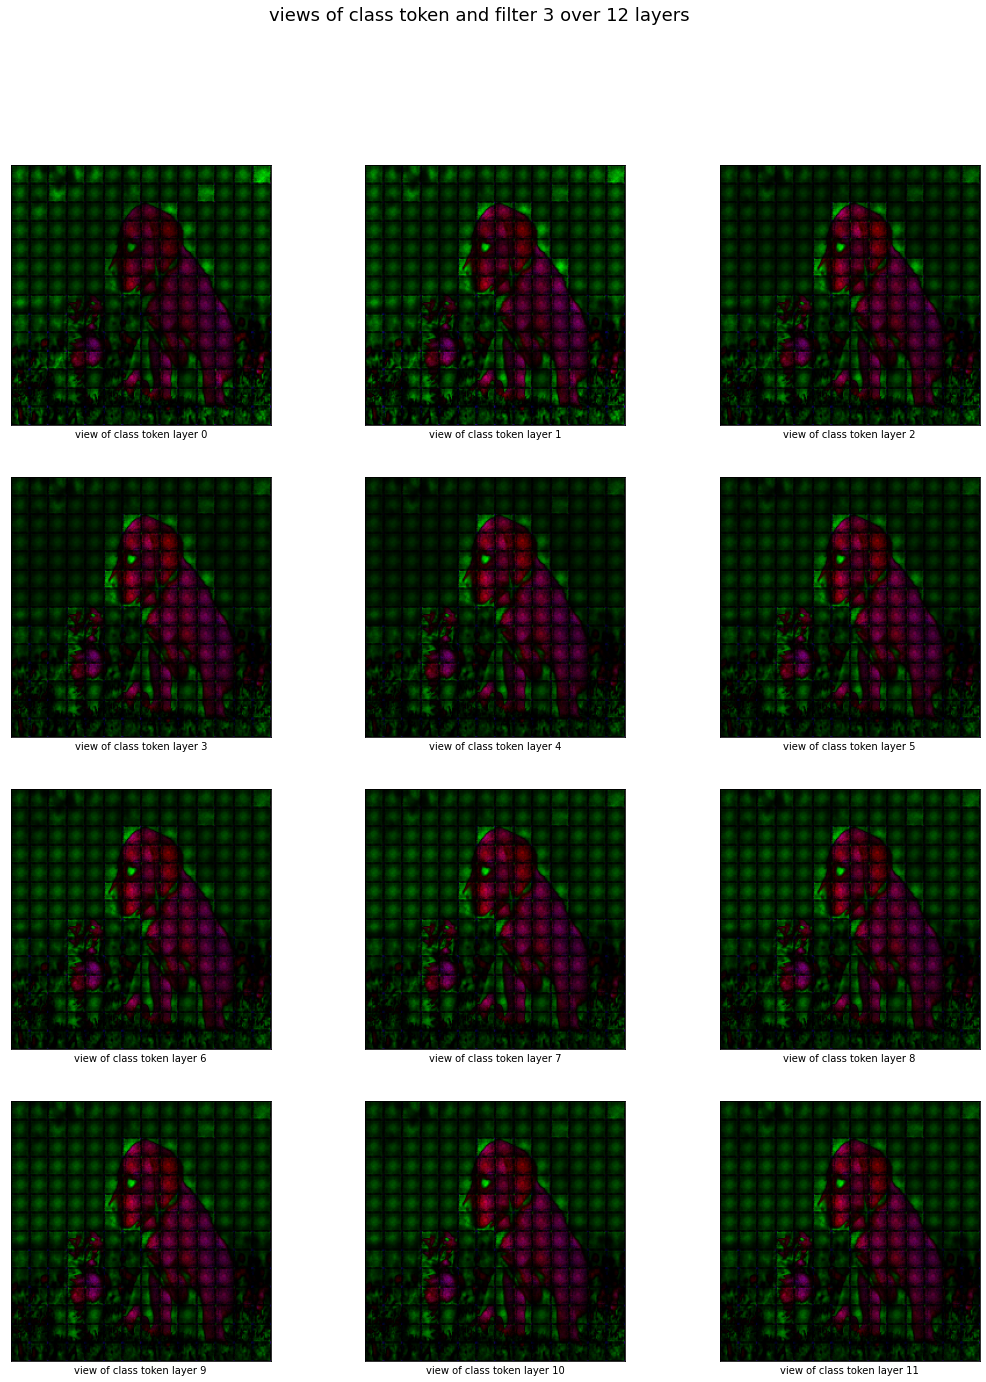

In [65]:
def _vis_act_map_of_clstk_same_filter(
    x: torch.Tensor, idx_filter: int = 0
  ):
  '''
  This function visualizes the global view of class token and a specific filter over 12 layers
  Args:
    x (torch.tensor): input image
    idx_filter (int): the index of filter
  '''
  fg, ax = plt.subplots(4, 3, figsize=(18, 22))
  fg.suptitle('views of class token and filter {} over 12 layers'.format(idx_filter), fontsize=18)
  idx_layer = 0
  for i in range(4):
    for j in range(3):
      activation_map = _create_activation_map_of_clstk_filter_layer(x, idx_filter = idx_filter, idx_layer = idx_layer)
      activation_map = activation_map/activation_map.max()
      activation_map = activation_map.clip(0, 1)
      ax[i, j].imshow(activation_map.detach().numpy())
      ax[i, j].set_xlabel('view of class token layer {}'.format(idx_layer))
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      idx_layer += 1

_vis_act_map_of_clstk_same_filter(x, idx_filter=3)

# Visualize dropout patches

In the next steps we will visualize occlusion includes salient, non-salient, and random drop patches.


## Salient drop

In [67]:
# Find index patch of object
from PIL import Image
import matplotlib.patheffects as PathEffects

def _occlude(im, grid_size=14, ids_patch = [], n_random_ocl = None):
  ids = np.arange(grid_size**2)
  im_cp = np.array(im)
  h, w = np.array(im).shape[:2]
  w_scale = w//grid_size
  h_scale = h//grid_size
  def _locate_xy(i):
    row_id = int(i//grid_size)
    col_id = i%grid_size
    row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
    col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
    return [row_star, row_end, col_star, col_end]
  if n_random_ocl:
    ids_patch = np.arange(196)
    np.random.shuffle(ids_patch)
    ids_patch = ids_patch[:n_random_ocl]
  for i in ids_patch:
    row_star, row_end, col_star, col_end = _locate_xy(i)
    im_cp[row_star:row_end, col_star:col_end, :] = 0
  return im_cp


ids_patch = [34, 35, 36, 48, 49, 50, 62, 63, 64, 65, 75, 76, 77, 78, 79, 89,90,91, 92, 93, 94, 105, 106, 107, 108,119, 120,121, 122, 123,
133, 134, 135, 136, 137, 147, 148, 149, 150, 151, 161, 162, 163, 164, 165,176, 179, 193] 
im_ocl = _occlude(im, grid_size=14, ids_patch = ids_patch)

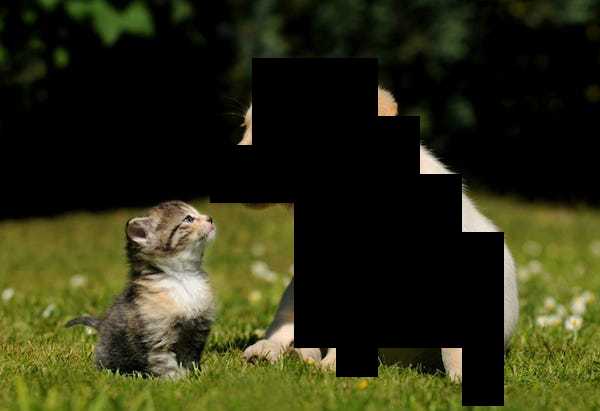

In [68]:
def _preprocess_array(im_arr):
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  ])
  im = Image.fromarray(im_arr)
  x = transform(im)
  return x, im

x, im_ocl = _preprocess_array(im_ocl)
im_ocl

In [96]:
def _vis_act_map_of_same_path_same_filter(x, idx_patch=0, idx_filter=0, kernel_size=9):
  fg, ax = plt.subplots(4, 3, figsize=(18, 22))
  fg.suptitle('views of patch {} filter {}'.format(idx_patch, idx_filter), fontsize=18)
  idx_layer = 0
  for i in range(4):
    for j in range(3):
      activation_map = _create_activation_map_of_patch_filter_layer(x, idx_patch = idx_patch, idx_filter = idx_filter, idx_layer = idx_layer)
      activation_map = activation_map/activation_map.max()
      activation_map = activation_map.detach().numpy()
      if kernel_size is not None:
        activation_map = cv2.blur(activation_map,(kernel_size, kernel_size))
      activation_map = activation_map.clip(0, 1)
      ax[i, j].imshow(activation_map)
      ax[i, j].set_xlabel('filter {}, layer {}'.format(idx_filter, idx_layer))
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      idx_layer += 1

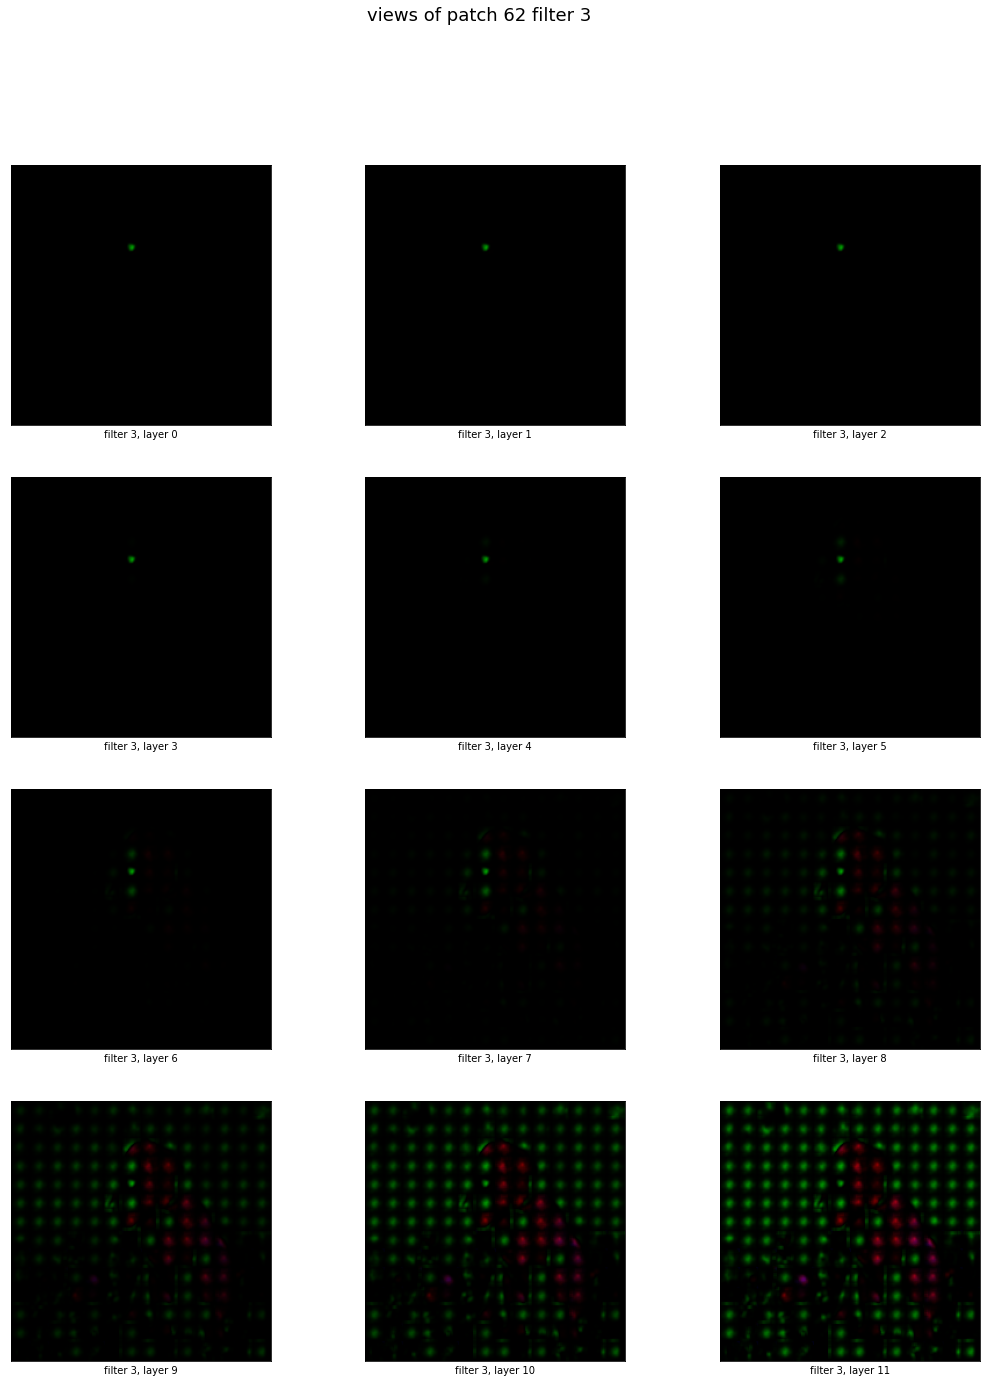

In [97]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=62, idx_filter=3, kernel_size=3)

## Non saliency

In [98]:
ids_patch_dog = [34, 35, 36, 48, 49, 50, 62, 63, 64, 65, 75, 76, 77, 78, 79, 
                 89, 90,91, 92, 93, 94, 105, 106, 107, 108,119, 120,121, 122, 123,
                 133, 134, 135, 136, 137, 147, 148, 149, 150, 151, 161, 162, 163, 164, 165,176, 179, 193] 
ids_patch_cat = [101, 102, 115, 116, 129, 130, 143, 144, 156, 157, 158, 170, 171, 172]
ids_obj = ids_patch_dog + ids_patch_cat
ids_patch = [i for i in range(196) if i not in ids_obj]

im_ocl = _occlude(im, grid_size=14, ids_patch = ids_patch)

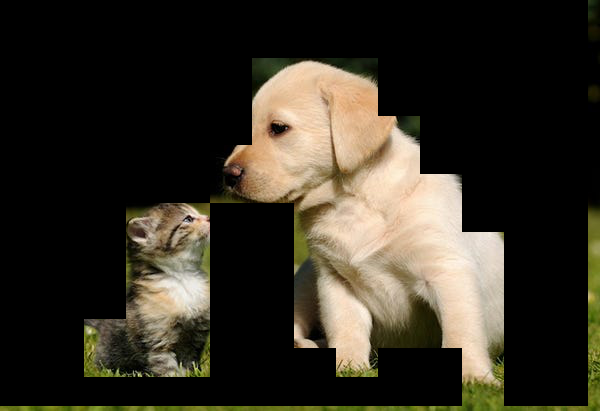

In [99]:
x, im_ocl = _preprocess_array(im_ocl)
im_ocl

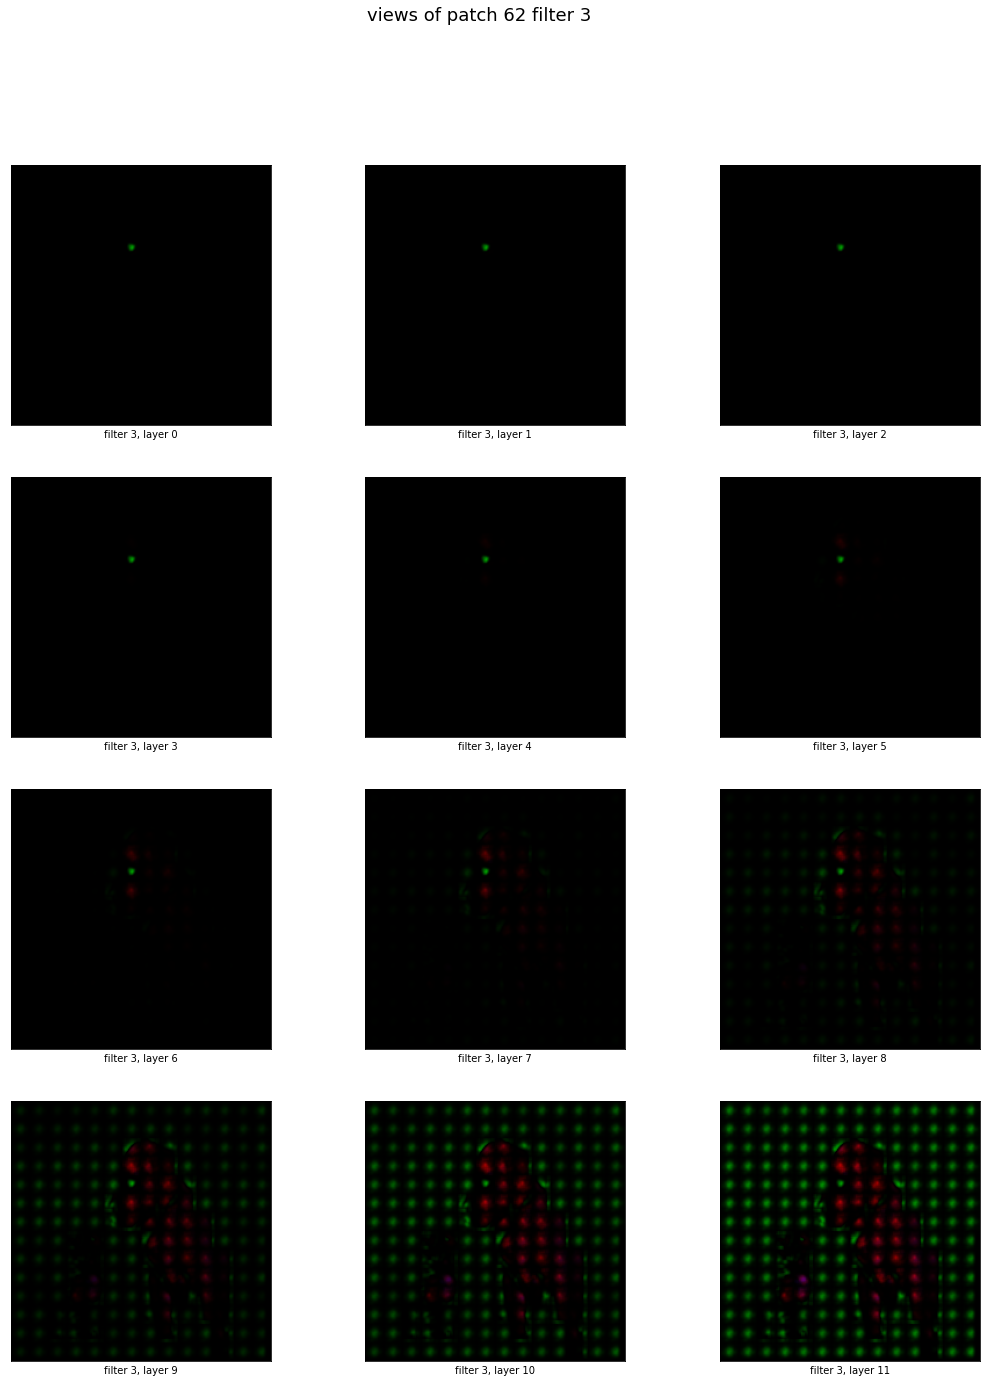

In [100]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=62, idx_filter=3, kernel_size=3)

## Random crop

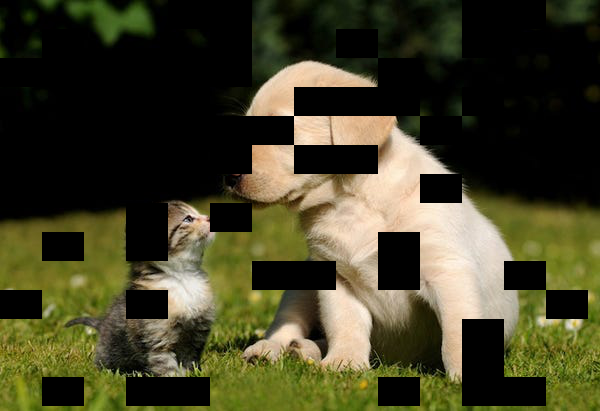

In [101]:
im_ocl = _occlude(im, n_random_ocl=50)
x, im_ocl = _preprocess_array(im_ocl)
im_ocl

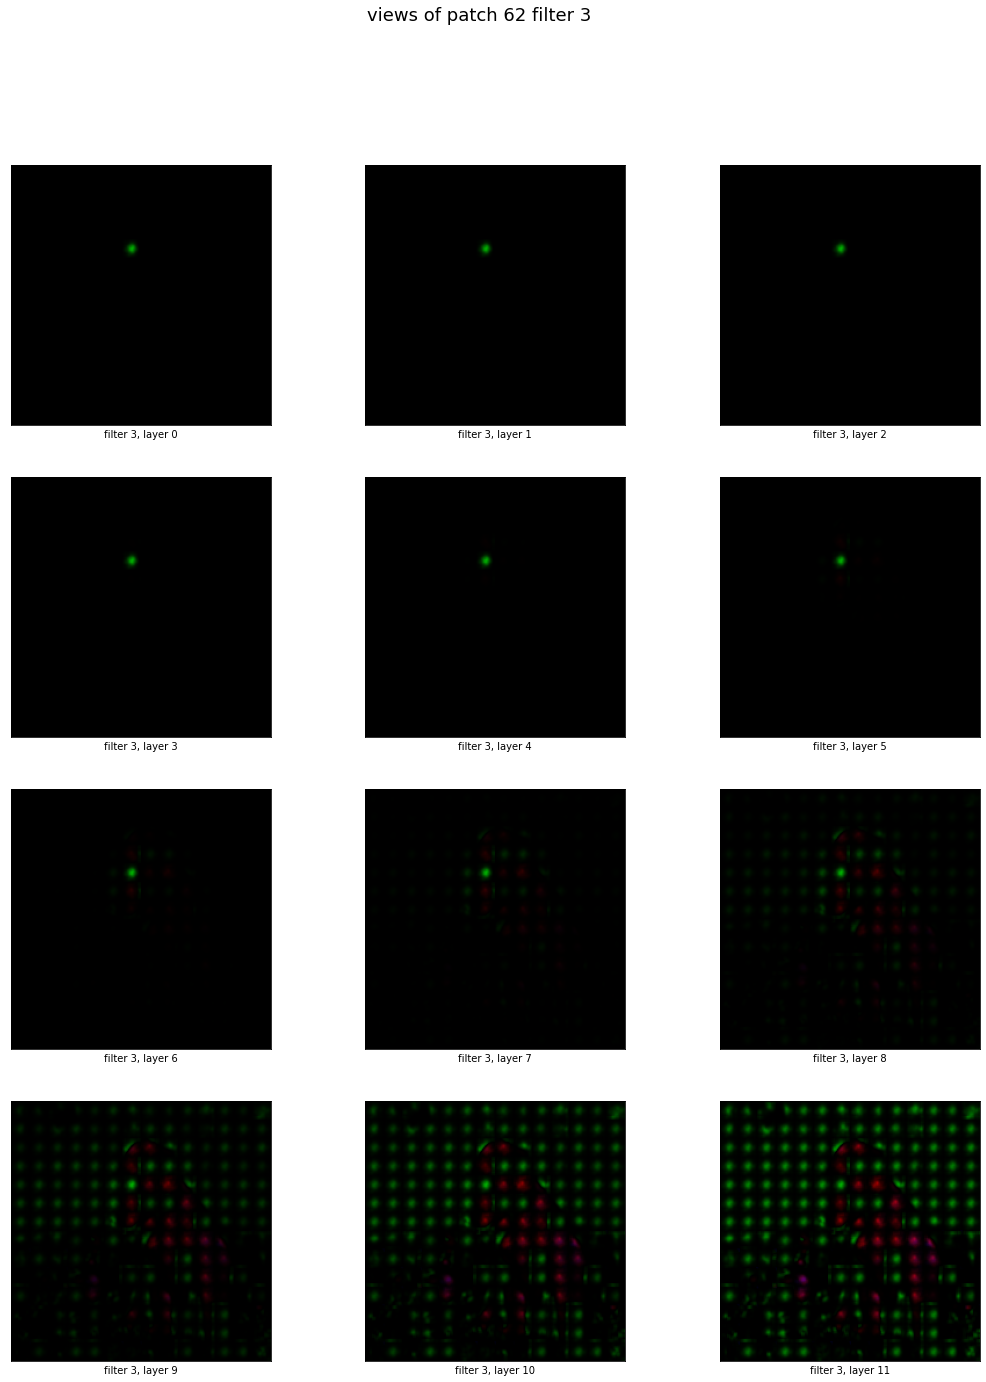

In [102]:
_vis_act_map_of_same_path_same_filter(x, idx_patch=62, idx_filter=3, kernel_size=3)